In [1]:
!pip install ultralytics

In [2]:
#This gives a cleaner terminal output -> No warnings
import warnings
warnings.filterwarnings('ignore')

#file manipulation
import os
import shutil

#Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Image Processing
import cv2
import yaml
from PIL import Image
from IPython.display import Video

#For YOLO (You Only Look Once)
from ultralytics import YOLO



In [3]:
sns.set_theme(rc={'axes.facecolor': '#008080'}, style='darkgrid')

### Importing YOLOs different sizes

In [4]:
model_nano = YOLO('yolov8n.pt')
model_small = YOLO('yolov8s.pt')
model_medium = YOLO('yolov8m.pt')

Currently the YOLOv8 model doesn't have the capability to predict for underwater objects. Let's train it so that it can make predictions

In [5]:
dataset_path = 'datasets'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Mask
- can
- cellphone
- electronics
- gbottle
- glove
- metal
- misc
- net
- pbag
- pbottle
- plastic
- rod
- sunglasses
- tire
nc: 15
path: /content/Data
roboflow:
  license: CC BY 4.0
  project: ocean_waste
  url: https://universe.roboflow.com/object-detect-dmjpt/ocean_waste/dataset/1
  version: 1
  workspace: object-detect-dmjpt
test: ../test/images
train: ../train/images
val: ../valid/images



In [6]:
train_image_path = 'datasets/train/images'
val_image_path = 'datasets/valid/images'

num_train_images = 0
num_valid_images = 0

# creating a set of train image sizes (sets are lists but the items are unchangable)
train_image_sizes = set()
val_image_sizes = set()

# checking the sizes and number of train images
for filename in os.listdir(train_image_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_image_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# checking the sizes and number of Val images
for filename in os.listdir(val_image_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(val_image_path, filename)
        with Image.open(image_path) as img:
            val_image_sizes.add(img.size)


print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")


if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(val_image_sizes) == 1:
    print(f"All validation images have the same size: {val_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")



Number of training images: 3628
Number of validation images: 1001
All training images have the same size: (416, 416)
All validation images have the same size: (416, 416)


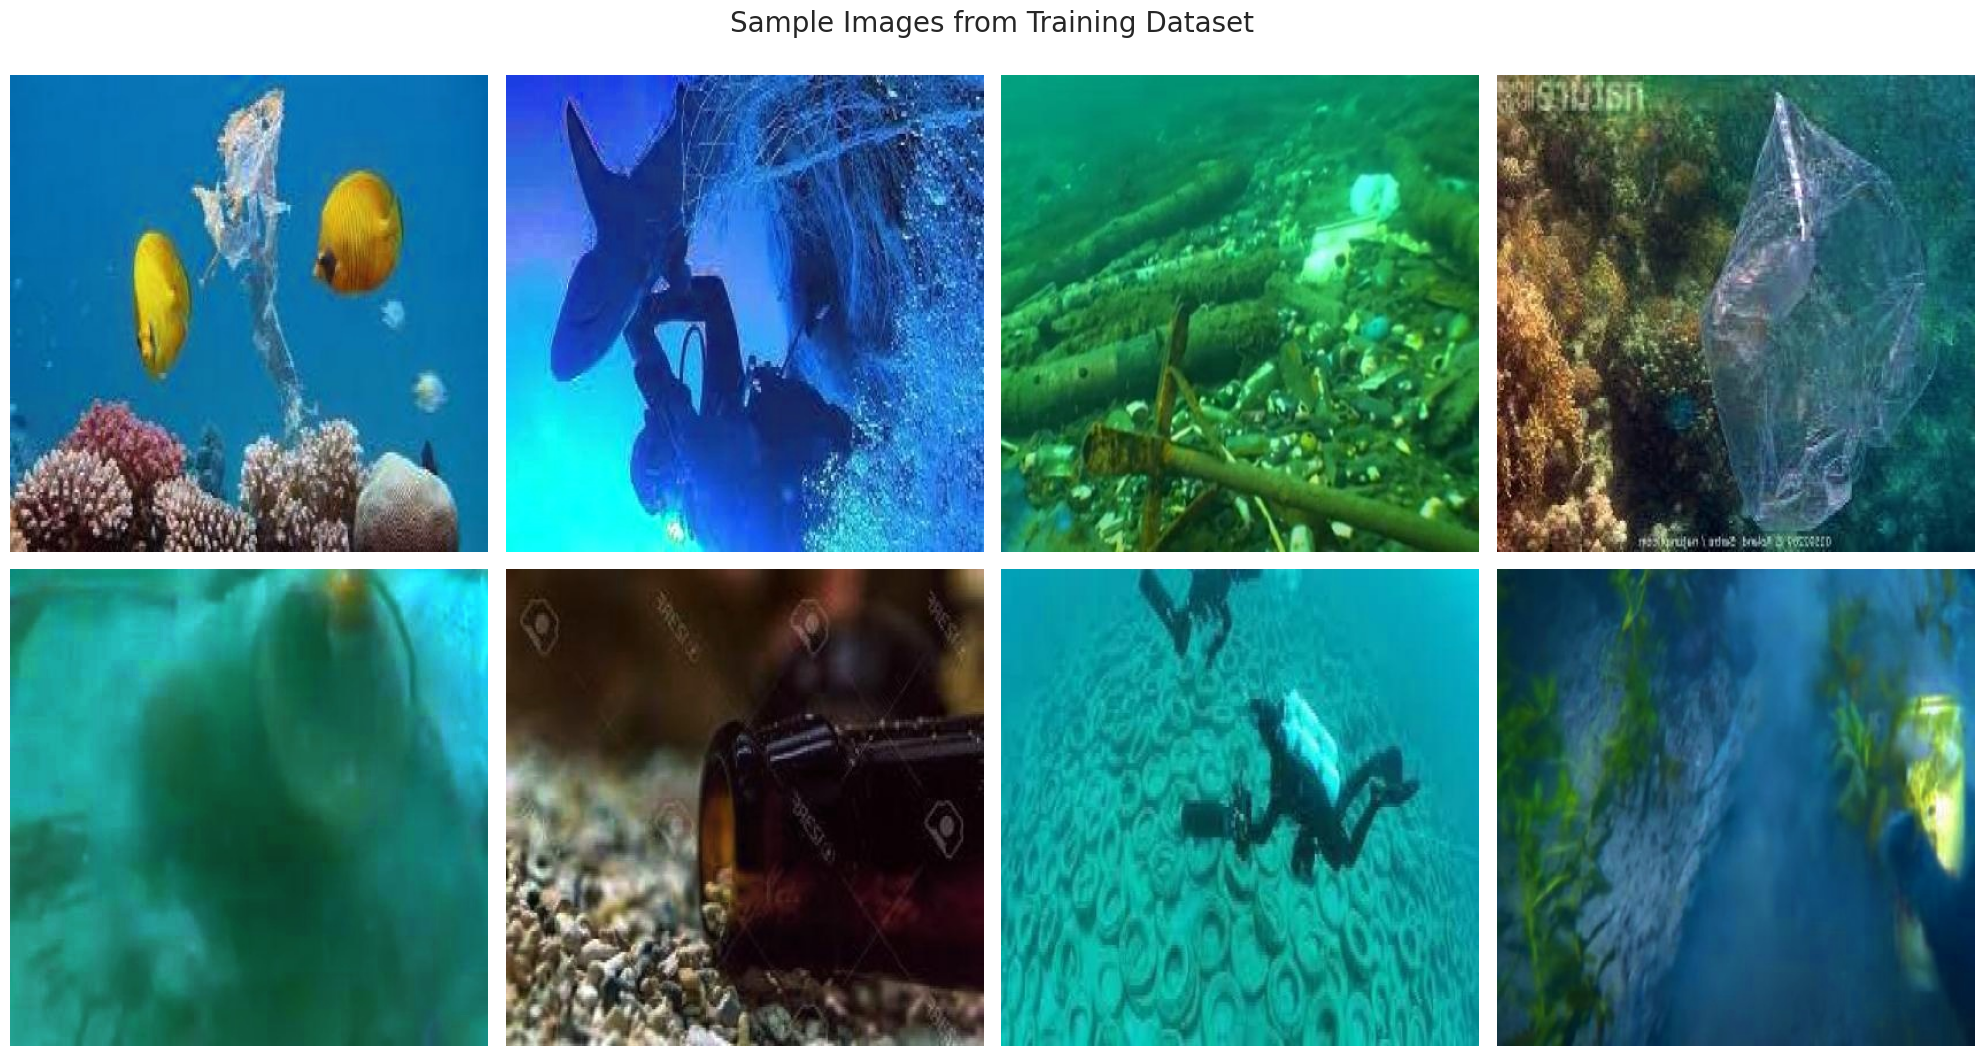

In [7]:
# List all jpg images in the directory
image_files = [file for file in os.listdir(train_image_path) if file.endswith('.jpg')]

# Select 8 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 8)]

# Create a 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 11))

# Display each of the selected images
for ax, img_file in zip(axes.ravel(), selected_images):
    img_path = os.path.join(train_image_path, img_file)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Sample Images from Training Dataset', fontsize=20)
plt.tight_layout()
plt.show()


### Fine Tuning Yolo

In [12]:
# Train the model on our custom dataset


# model.train(data=yaml_file_path, epochs=100, imgsz=416)


results = model_nano.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=100,              # Number of epochs to train for
    imgsz=416,               # Size of input images as integer
    device=0  ,               # Device to run on, i.e. cuda device=0
    patience=50,             # Epochs to wait for no observable improvement for early stopping of training
    batch=32,                # Number of images per batch
    optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.1,             # Use dropout regularization
    seed=0                   # Random seed for reproducibility
)

Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/data.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /content/datasets/train/labels.cache... 3628 images, 2 backgrounds, 0 corrupt: 100%|██████████| 3628/3628 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/valid/labels.cache... 1001 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.07G       1.49      3.465      1.524         39        416: 100%|██████████| 114/114 [00:42<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]

                   all       1001       1891       0.51      0.212      0.154      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.06G      1.503      2.365      1.507         80        416: 100%|██████████| 114/114 [00:40<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


                   all       1001       1891      0.644      0.237      0.249      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.1G      1.477      2.097      1.478         92        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1001       1891      0.498      0.273       0.24      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.02G       1.47      2.007      1.474         61        416: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


                   all       1001       1891      0.748      0.259      0.272      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.06G       1.43      1.884       1.44         43        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1001       1891        0.7      0.294      0.319      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.05G      1.416      1.796      1.432         50        416: 100%|██████████| 114/114 [00:38<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all       1001       1891      0.629      0.275      0.299      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.98G      1.392      1.717      1.411         27        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]


                   all       1001       1891      0.647      0.311      0.339      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.06G      1.375      1.656      1.401         43        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.675      0.354      0.394      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.05G      1.362      1.621      1.398         60        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]


                   all       1001       1891      0.652      0.341      0.395      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.05G      1.364      1.564      1.385         92        416: 100%|██████████| 114/114 [00:37<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]

                   all       1001       1891      0.788       0.35        0.4      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.02G      1.345       1.52      1.374         37        416: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

                   all       1001       1891      0.566      0.407      0.414      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.06G      1.325      1.475      1.368         52        416: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1001       1891      0.586      0.427      0.481      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.89G      1.323      1.452      1.362         65        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all       1001       1891      0.664      0.375      0.413      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.97G      1.302      1.408      1.358         49        416: 100%|██████████| 114/114 [00:38<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1001       1891      0.469      0.461      0.466      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.02G      1.297        1.4      1.348         56        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

                   all       1001       1891      0.431      0.406      0.374      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.03G      1.285      1.368       1.34         32        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1001       1891      0.661      0.379      0.453      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.06G      1.288      1.346      1.341         46        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.29it/s]

                   all       1001       1891      0.712      0.392       0.45      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.06G      1.277      1.322      1.339         41        416: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all       1001       1891      0.543       0.47      0.518      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.05G      1.274      1.294      1.332         51        416: 100%|██████████| 114/114 [00:39<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1001       1891      0.544      0.445      0.472      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.02G      1.267      1.273      1.327         62        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all       1001       1891      0.686      0.426      0.467      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.05G      1.251      1.261      1.317         45        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1001       1891      0.573      0.414      0.466      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.06G       1.25      1.263      1.319         60        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.554      0.462       0.53      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.04G      1.234      1.228       1.31         64        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1001       1891      0.643      0.475      0.512      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.06G      1.243      1.228      1.312         58        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.557      0.543      0.526      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.06G      1.259      1.204      1.318         89        416: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1001       1891      0.646      0.426       0.47      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.05G       1.24      1.189      1.305         57        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all       1001       1891      0.656      0.467      0.542      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.04G      1.224      1.153      1.289         63        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all       1001       1891      0.711      0.466      0.509      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.02G       1.23      1.153      1.291         36        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1001       1891      0.528        0.5      0.541      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.05G      1.208      1.146      1.293         39        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]

                   all       1001       1891      0.503      0.453      0.484       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.98G      1.198      1.114      1.282         34        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1001       1891      0.575      0.517      0.549       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       1.9G      1.202      1.117      1.283         45        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]

                   all       1001       1891      0.627      0.515      0.566      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.04G      1.198      1.102      1.277         47        416: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1001       1891      0.764      0.441      0.525      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.92G      1.191      1.099      1.272         43        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

                   all       1001       1891      0.501      0.562      0.549      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.91G      1.187      1.074      1.272         41        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1001       1891      0.581      0.501      0.531      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.06G       1.19       1.08      1.276         75        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.614      0.476      0.536      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.05G      1.187      1.075      1.267         31        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1001       1891      0.574      0.535      0.595      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.02G      1.179      1.067      1.267         38        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1001       1891      0.732       0.49      0.593      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.02G      1.174       1.05      1.257         51        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all       1001       1891      0.638      0.551      0.591      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.04G      1.159      1.038      1.251         72        416: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1001       1891      0.627      0.608      0.636      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.04G      1.161      1.028      1.257         60        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1001       1891      0.654      0.528      0.586      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.04G      1.143     0.9919      1.247         55        416: 100%|██████████| 114/114 [00:38<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1001       1891      0.749      0.514      0.609      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.06G      1.164      1.014      1.259         56        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]

                   all       1001       1891      0.587      0.599      0.626      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.06G      1.151     0.9914      1.239         39        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1001       1891      0.664      0.579      0.618      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.05G      1.149     0.9882      1.245         41        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.656      0.571      0.618      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.04G      1.132     0.9816      1.238         87        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1001       1891       0.67      0.579      0.642      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.06G      1.147     0.9764      1.245         35        416: 100%|██████████| 114/114 [00:40<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all       1001       1891      0.649      0.579       0.65      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.98G      1.152     0.9759      1.239         36        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1001       1891      0.672      0.611       0.66      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.06G      1.118     0.9451      1.229         40        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1001       1891      0.709      0.537      0.626      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.04G      1.115     0.9379       1.23         37        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all       1001       1891      0.661      0.543      0.609      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.05G      1.114      0.938      1.224         43        416: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1001       1891      0.651      0.651      0.654      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.04G      1.139     0.9446      1.235         76        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]

                   all       1001       1891       0.65      0.633      0.675      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.04G      1.121     0.9319       1.23         55        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1001       1891      0.687      0.608      0.673      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.04G      1.117     0.9377      1.227         46        416: 100%|██████████| 114/114 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]

                   all       1001       1891      0.734      0.602       0.68      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.04G      1.107     0.9191       1.22         56        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1001       1891      0.643      0.646      0.684      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.02G      1.095     0.9112      1.214         42        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

                   all       1001       1891      0.671      0.683      0.712      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.05G      1.098     0.9005      1.211         36        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1001       1891      0.722      0.651        0.7      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.04G      1.096     0.9014      1.215         41        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all       1001       1891      0.694       0.65      0.697      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.04G      1.102     0.8963      1.217         61        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all       1001       1891      0.743      0.648       0.72      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.91G      1.092     0.8939       1.21         48        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1001       1891      0.665      0.698      0.719      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         2G       1.09      0.878      1.198         56        416: 100%|██████████| 114/114 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all       1001       1891      0.694      0.631      0.708      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.04G      1.098      0.884       1.21         47        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1001       1891       0.72      0.628      0.694      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.91G      1.075     0.8746      1.202         43        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all       1001       1891      0.704      0.695      0.718      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.05G      1.075     0.8614      1.193         70        416: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1001       1891      0.766      0.651      0.733      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.04G      1.074      0.866      1.196         48        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all       1001       1891      0.768       0.65      0.733      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.06G      1.075     0.8591      1.196         55        416: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1001       1891      0.765      0.689       0.74      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       1.9G      1.058     0.8301      1.188         64        416: 100%|██████████| 114/114 [00:38<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1001       1891      0.776      0.663      0.744      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.97G      1.093     0.8545      1.202         45        416: 100%|██████████| 114/114 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]

                   all       1001       1891      0.758      0.659      0.724       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.91G      1.059     0.8296      1.186         62        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1001       1891      0.783      0.694      0.758      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.92G      1.058     0.8238      1.183         32        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]

                   all       1001       1891      0.727      0.697      0.747      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.05G       1.05     0.8271      1.183         64        416: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]

                   all       1001       1891      0.763      0.663      0.728      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.91G      1.069     0.8274      1.193         44        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

                   all       1001       1891      0.822      0.692      0.762      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.91G      1.037     0.8069      1.182         35        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1001       1891      0.779      0.685       0.75       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.98G      1.043     0.8223      1.178         54        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all       1001       1891      0.786       0.65      0.727      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       1.9G      1.049     0.8125      1.178         43        416: 100%|██████████| 114/114 [00:39<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1001       1891      0.764      0.678      0.744      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.04G      1.039     0.8122      1.176         36        416: 100%|██████████| 114/114 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all       1001       1891      0.761      0.704      0.749       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.99G      1.042     0.8048      1.184         40        416: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all       1001       1891      0.805       0.65      0.744      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.98G      1.041     0.8063      1.178         69        416: 100%|██████████| 114/114 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1001       1891       0.79      0.698      0.771      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.04G      1.034     0.7967      1.174         62        416: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

                   all       1001       1891      0.792      0.705      0.759       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.05G      1.044     0.8051      1.178         56        416: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1001       1891      0.775      0.703      0.765      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.06G      1.042     0.7906      1.173         39        416: 100%|██████████| 114/114 [00:38<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all       1001       1891      0.781       0.69      0.747      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.97G      1.033     0.7893      1.171         94        416: 100%|██████████| 114/114 [00:40<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all       1001       1891      0.843      0.685      0.764      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.04G      1.021     0.7707      1.164         56        416: 100%|██████████| 114/114 [00:38<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]

                   all       1001       1891      0.825      0.668      0.766      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.02G      1.015     0.7776      1.168         35        416: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all       1001       1891       0.81       0.71      0.781      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.05G      1.022     0.7702      1.163         42        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1001       1891      0.804      0.714      0.768      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.05G      1.011     0.7613       1.16         55        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]

                   all       1001       1891      0.848      0.685      0.773      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         2G      1.006     0.7593      1.161         44        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1001       1891      0.792      0.732      0.769      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.04G      1.014     0.7642      1.158         58        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]

                   all       1001       1891      0.784       0.73      0.766       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.04G       1.01     0.7567      1.162         63        416: 100%|██████████| 114/114 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all       1001       1891      0.821      0.708      0.775      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.04G      1.012     0.7571      1.162         47        416: 100%|██████████| 114/114 [00:39<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1001       1891      0.841      0.714      0.788      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.06G       1.02     0.7564      1.158         57        416: 100%|██████████| 114/114 [00:39<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1001       1891      0.804        0.7      0.767      0.482


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.05G     0.9332     0.6034      1.119         18        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1001       1891      0.751      0.736      0.763      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.98G     0.9193     0.5743      1.112         21        416: 100%|██████████| 114/114 [00:36<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all       1001       1891      0.843      0.681      0.772      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.04G     0.9103     0.5661      1.103         31        416: 100%|██████████| 114/114 [00:35<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1001       1891      0.761      0.745      0.782      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.04G     0.9071     0.5621      1.105         29        416: 100%|██████████| 114/114 [00:36<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1001       1891      0.761      0.726      0.775      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.05G     0.9076     0.5574      1.107         21        416: 100%|██████████| 114/114 [00:36<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all       1001       1891      0.843      0.718      0.796      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.04G      0.896     0.5555      1.101         48        416: 100%|██████████| 114/114 [00:35<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all       1001       1891      0.813      0.725      0.797      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.04G     0.8907     0.5411      1.097         27        416: 100%|██████████| 114/114 [00:36<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1001       1891      0.803      0.739      0.789      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.04G     0.8858     0.5383      1.095         42        416: 100%|██████████| 114/114 [00:36<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all       1001       1891      0.768      0.749      0.789      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.04G      0.881     0.5313      1.093         15        416: 100%|██████████| 114/114 [00:40<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

                   all       1001       1891      0.823      0.733      0.791      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.05G     0.8822     0.5343      1.087         46        416: 100%|██████████| 114/114 [00:38<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]

                   all       1001       1891      0.843      0.712       0.79      0.497



100 epochs completed in 1.277 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all       1001       1891      0.826       0.71       0.79      0.498
                  Mask       1001         90      0.969      0.699      0.883      0.627
                   can       1001         20      0.922       0.59      0.689      0.285
             cellphone       1001         71       0.96      0.972      0.992      0.877
           electronics       1001         40      0.833       0.75      0.783      0.469
               gbottle       1001         82      0.739      0.683      0.705      0.514
                 glove       1001         55      0.858      0.764        0.9      0.718
                 metal       1001         22      0.431      0.273      0.298       0.19
                  misc       1001         51      0.661       0.65      0.723      0.396
                   net       1001        148      0.906      0.908      0.959       0.69
                  pbag       1001        330      0.876      0.982      0.973      0.848
               pbottl

In [17]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [27]:
!zip -r /content/runs/detect/train12.zip /content/datasets/

Streaming output truncated to the last 5000 lines.
  adding: content/datasets/train/images/uwg_g-862__fliph_jpg.rf.d2bac702e3c01d63456608f27ab67615.jpg (deflated 1%)
  adding: content/datasets/train/images/uwg_g-907__fliph_jpg.rf.5e8d2cefff7c3a6ad593b2cfa3d2f346.jpg (deflated 2%)
  adding: content/datasets/train/images/uwg_g-1131__flipv_jpeg_jpg.rf.caf1eee99d8debdd3ab4d33752a2becb.jpg (deflated 1%)
  adding: content/datasets/train/images/uwg_g-255__fliph_jpeg_jpg.rf.fe4dffbc3298f8f33377514da7c244d3.jpg (deflated 2%)
  adding: content/datasets/train/images/uwg_g-56__fliph_jpg.rf.766b5d72db94d9ed3d2c2139b913d94c.jpg (deflated 2%)
  adding: content/datasets/train/images/uwg_yt-147__fliph_png_jpg.rf.7f1540f529eeb0a03c53bf48303298e7.jpg (deflated 2%)
  adding: content/datasets/train/images/uwg_g-947_jpg.rf.9ee99f5e65a5ddd99219bfe5dbb789df.jpg (deflated 2%)
  adding: content/datasets/train/images/mask_in_the_ocean_35_jpg.rf.e065342318eff0228c999fcc4ca4b0e2.jpg (deflated 3%)
  adding: content

In [24]:
model = YOLO('yolov8n.yaml')

model.info()



YOLOv8n summary: 225 layers, 3157200 parameters, 3157184 gradients, 8.9 GFLOPs


(225, 3157200, 3157184, 8.8575488)

In [25]:
model.train(data=yaml_file_path, epochs=5, imgsz=416, device=0, lr0=0.01,              # Initial learning rate
    lrf=0.1,                 # Final learning rate (lr0 * lrf)
    dropout=0.1,             # Use dropout regularization
    seed=0,
    optimizer='auto')

Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=datasets/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/datasets/train/labels.cache... 3628 images, 2 backgrounds, 0 corrupt: 100%|██████████| 3628/3628 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/valid/labels.cache... 1001 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.21G      3.629      4.876      4.144         48        416: 100%|██████████| 227/227 [00:49<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


                   all       1001       1891      0.134     0.0273    0.00119   0.000323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.06G      3.229      4.368       3.66         59        416: 100%|██████████| 227/227 [00:46<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


                   all       1001       1891      0.747    0.00828    0.00883    0.00255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.06G      2.799      3.978      3.176         41        416: 100%|██████████| 227/227 [00:46<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


                   all       1001       1891      0.546      0.016     0.0132    0.00527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.12G      2.558      3.711      2.872         42        416: 100%|██████████| 227/227 [00:46<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]


                   all       1001       1891      0.503     0.0456     0.0301     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.06G      2.401      3.473      2.693         38        416: 100%|██████████| 227/227 [00:46<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


                   all       1001       1891      0.451     0.0476     0.0305     0.0131

5 epochs completed in 0.077 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 6.2MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


                   all       1001       1891      0.451     0.0479     0.0305      0.013
                  Mask       1001         90     0.0383     0.0556     0.0109    0.00325
                   can       1001         20          1          0    0.00261   0.000681
             cellphone       1001         71       0.12     0.0704     0.0462     0.0211
           electronics       1001         40          1          0    0.00545    0.00144
               gbottle       1001         82          1          0   0.000318   3.18e-05
                 glove       1001         55          0          0    0.00346    0.00115
                 metal       1001         22          0          0          0          0
                  misc       1001         51          1          0    0.00798    0.00318
                   net       1001        148      0.189       0.12     0.0974     0.0313
                  pbag       1001        330       0.22      0.439      0.231      0.115
               pbottl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e9a37a60f40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

In [ ]:
finetuned_model = 